# 목차
- 데이터 전처리
- Correlation
- PCA Biplot
- Clustering
- Granger 인과관계 분석

In [ ]:
import os
os.chdir('/content/drive/MyDrive/코랩/T 아카데미/금융 리서치')

In [ ]:
import pandas as pd
import glob
from scipy import interpolate
import numpy as np
from functools import reduce
from datetime import datetime, date
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import scipy.stats as stats

In [ ]:
comm = glob.glob('./data/*.csv')

In [ ]:
# 각 상품의 데이터를 해당 변수에 저장
for comm_dat in comm:
  vars()[comm_dat[7:-4]] = pd.read_csv(comm_dat, low_memory=False)

In [ ]:
# ticker 데이터 따로 추출

tic_list = []
for dat in [World_Index,MoneyMarket,MSCI,Barclays,commodity]:
  for tic in np.unique(dat['ticker']):
    tic_list.append(tic.replace(' ','_'))
    vars() [tic.replace(' ','_')] = dat[dat['ticker'] == tic]

In [ ]:
for i in tic_list:
  if min(eval(i)['bas_dt']) <= '2005':
    print('{}'.format(i),min(eval(i)['bas_dt']))

TK_BKX_Index 1992-05-22
TK_CAC_Index 1987-07-09
TK_CCMP_Index 1980-01-02
TK_CRTX_Index 1997-10-08
TK_DAX_Index 1980-01-02
TK_HSCEI_Index 1993-07-15
TK_HSI_Index 1980-01-02
TK_IBOV_Index 1980-01-02
TK_INDU_Index 1980-01-02
TK_KOSDAQ_Index 1996-07-01
TK_KOSPI_Index 1980-01-04
TK_MID_Index 1990-12-31
TK_NKY_Index 1980-01-04
TK_OEX_Index 1980-01-02
TK_SHCOMP_Index 1990-12-19
TK_SMI_Index 1988-07-01
TK_SML_Index 1993-12-31
TK_SOX_Index 1994-05-02
TK_SPX_Index 1980-01-02
TK_SX5E_Index 1986-12-31
TK_SZCOMP_Index 1992-01-02
TK_TPX_Index 1980-01-04
TK_VNINDEX_Index 2000-07-28
TK_XAU_Index 1983-12-19
TK_BPDR1T_Curncy 1997-01-23
TK_CABROVER_Index 1992-12-01
TK_CHLR12M_Index 1991-04-21
TK_EURR002W_Index 1998-12-18
TK_FDTR_Index 1980-01-01
TK_GTGBP2Y_Corp 1992-01-02
TK_GTGBP30Y_Corp 1992-12-10
TK_GTGBP3Y_Corp 1992-01-02
TK_GTGBP5Y_Corp 1992-01-01
TK_GTGBP7Y_Corp 1992-01-01
TK_GTGBPII10Y_Corp 1992-07-17
TK_GTJPY10Y_Corp 1989-04-03
TK_GTJPY2Y_Corp 1994-02-09
TK_GTJPY30Y_Corp 1999-09-02
TK_GTJPY3Y_Cor

### 데이터 전처리

- 1년 간 수익률 function

In [ ]:
# 각 Ticker 별로 종가만 추출

def financial_PR(datasets):
  product_list = []
  for idx in range(len(datasets)):
    data = datasets[idx]
    data = data.copy()
    if data.iat[0,7] == 'Barclays':
      category = 'diff'
    else:
      category = 'return'
    # ---------------- px_last 변수 정의
    name = np.unique(data['ticker1'])[0].replace(' ','_')
    data.rename(columns = {'px_last' : name},inplace = True)
    data = data.loc[:,['bas_dt',name]]

    # ---------------- 날짜 인덱스 변경
    data['bas_dt'] = data['bas_dt'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d'))
    data = data.reset_index().drop('index',axis = 1).set_index('bas_dt')

    # ---------------- 날짜 일별로 resampling (각 상품의 일 별 데이터 값이 동일하지 않음.)
    data = data.resample('D').first() # 일정한 주기 데이터 생성 (동일한 날짜 간격)
    data = data.interpolate()

    if name in ['TK_GTUSD2Y_Govt', 'TK_GTUSD10Y_Govt']:
      pass
    else:
      if category == 'return':
        if name in ['TK_SPX_Index','TK_KOSPI_Index','TK_NKY_Index']:
          data['{}_365'.format(name)] = data.pct_change(365)
        else:
          data = data.pct_change(365)
      else:
        data = data.diff(365)    
    
    data = data.loc['1997-03-31':,:] # 1981-04-14 부터

    product_list.append(data)
  return product_list

- 일주일 간 수익률 function (하루치 단위가 아닌 일주일치 단위)

In [ ]:
def fr_PR(datasets,fr='M'):
  product_list = []
  for idx in range(len(datasets)):
    data = datasets[idx]
    data = data.copy()
    if data.iat[0,7] == 'Barclays':
      category = 'diff'
    else:
      category = 'return'
    # ---------------- px_last 변수 정의
    name = np.unique(data['ticker1'])[0].replace(' ','_')
    data.rename(columns = {'px_last' : name},inplace = True)
    data = data.loc[:,['bas_dt',name]]
    # ---------------- 날짜 인덱스 변경
    data['bas_dt'] = data['bas_dt'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d'))
    data = data.reset_index().drop('index',axis = 1).set_index('bas_dt')

    # ---------------- 날짜 일별로 resampling (각 상품의 일 별 데이터 값이 동일하지 않음.)
    data = data.resample('D').first() # 일정한 주기 데이터 생성 (동일한 날짜 간격)
    data = data.interpolate()
    data = data.loc['2001':,:] # 1981-04-14 부터

    # --------------- 일주일 or 한달간의 수익률 계산 
    week_end = pd.date_range(data.index[0], data.index[-1], freq=fr)
    data_week = data[data.index.isin(week_end)]

    if name in ['TK_GTUSD2Y_Govt', 'TK_GTUSD10Y_Govt']:
      pass
    else:
      if category == 'return':
        data_week = data_week.pct_change()
      else:
        data_week = data_week.diff()    

    product_list.append(data_week)

  return product_list

In [ ]:
PCA_product = [TK_CAC_Index, TK_CCMP_Index, TK_CRTX_Index, TK_DAX_Index, TK_HSCEI_Index, TK_HSI_Index, TK_IBOV_Index, TK_INDU_Index, TK_KOSDAQ_Index, TK_KOSPI_Index, TK_MID_Index, TK_NKY_Index, TK_OEX_Index,
TK_SMI_Index, TK_SML_Index, TK_SPX_Index, TK_SX5E_Index, TK_TPX_Index, TK_USDBRL_BGN_Curncy, TK_USDCHF_BGN_Curncy, TK_USDESP_BGN_Curncy, TK_USDGRD_BGN_Curncy, TK_USDINR_BGN_Curncy, TK_USDITL_BGN_Curncy, 
TK_USDKRW_BGN_Curncy,TK_USDMXN_BGN_Curncy, TK_USDMYR_BGN_Curncy, TK_USDRUB_BGN_Curncy, TK_USDTRY_BGN_Curncy, TK_USDTWD_BGN_Curncy, TK_GTUSD2Y_Govt, TK_BAC1TRUU_Index, TK_BEBGTRUU_Index, TK_BGLCTRUU_Index,
TK_BUT5TRUU_Index, TK_LBUTTRUU_Index, TK_LGC1TRUU_Index, TK_LT08TRUU_Index, TK_LT10TRUU_Index, TK_LT11TRUU_Index, TK_LT12TRUU_Index, TK_LT51TRUU_Index, TK_LTI1TRUU_Index, TK_LTR1TRUU_Index, TK_LUTLTRUU_Index]

In [ ]:
Month_product_list = fr_PR(PCA_product,'M')
Month_merge = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how = 'outer'),Month_product_list)
# Month_merge.dropna(axis=0,inplace=True)

In [ ]:
Month_merge = Month_merge.loc['2005':].dropna(axis=1)

### Correlation

<ipython-input-86-77a6295e2c80>:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(df, dtype=np.bool)


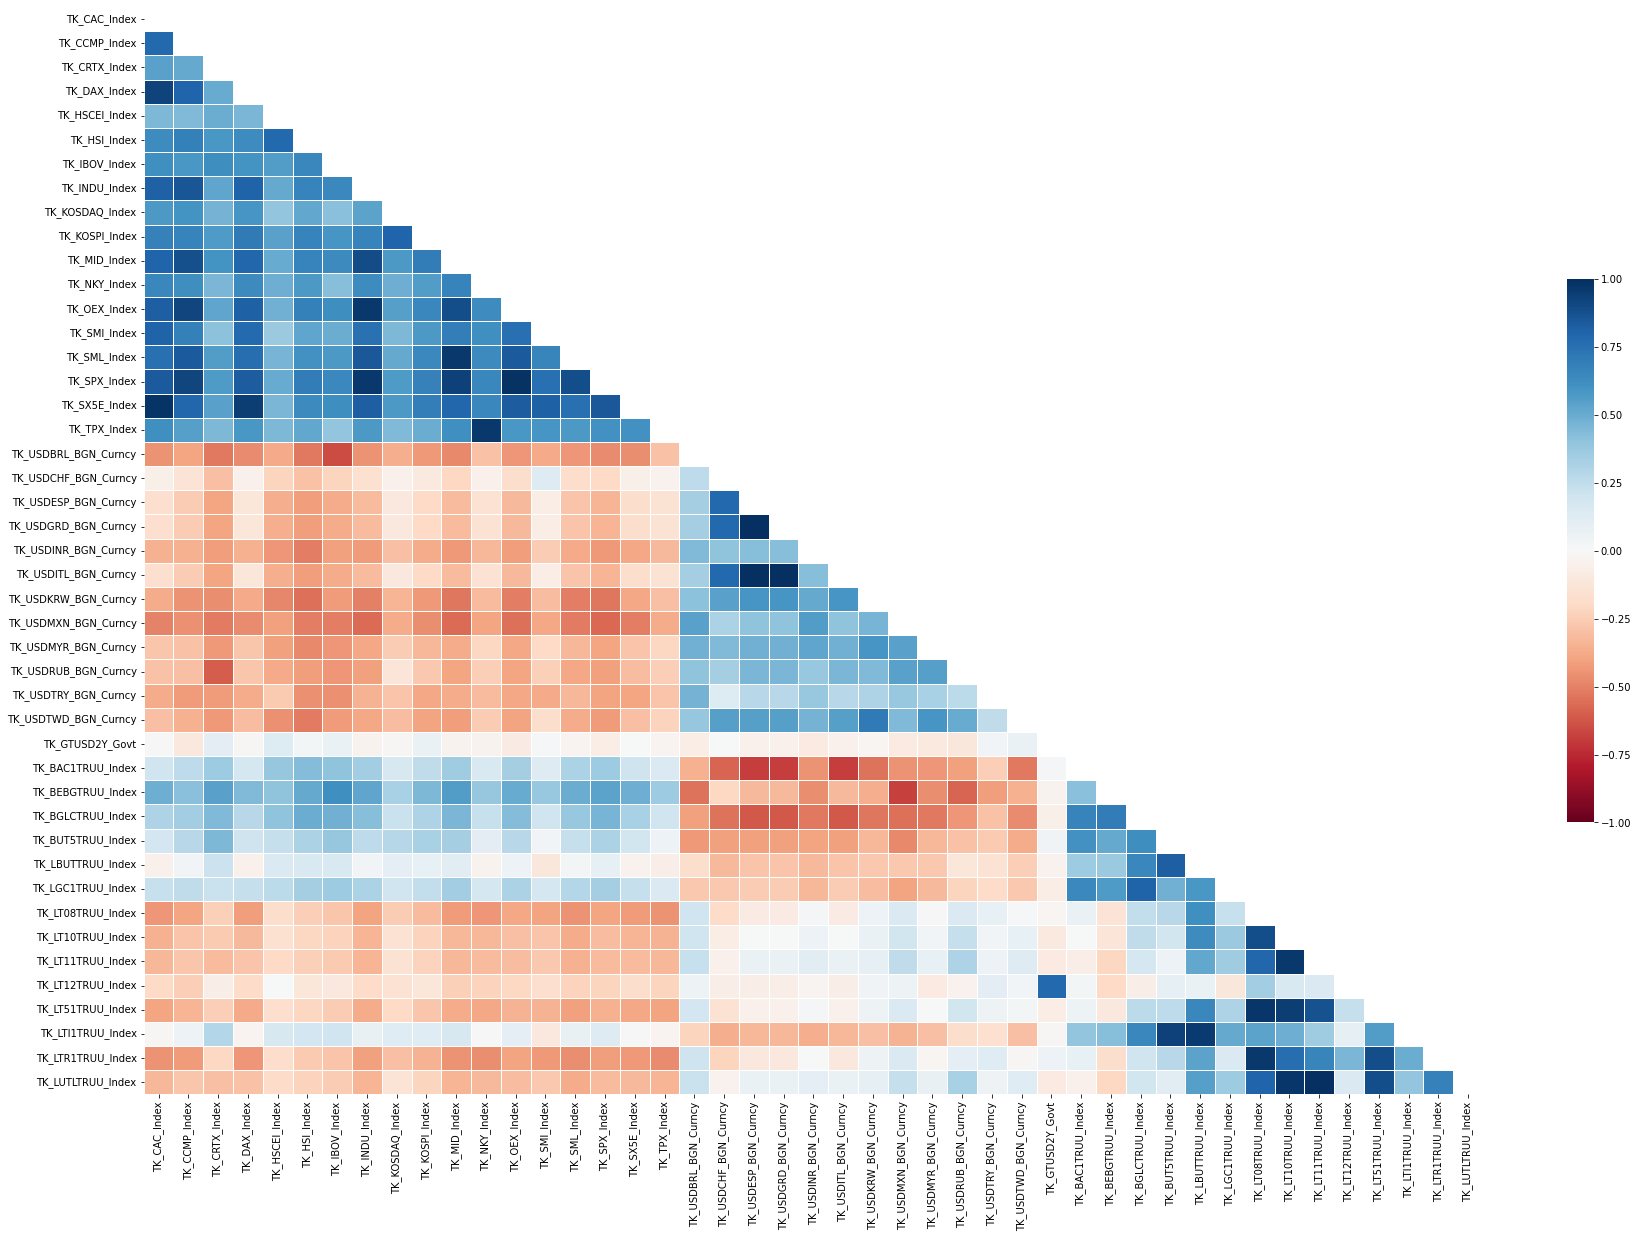

In [ ]:
df = Month_merge.corr()
# 그림 사이즈 지정
fig, ax = plt.subplots( figsize=(30,20) )

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(df, 
            cmap='RdBu', 
            annot = False,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()

### PCA Biplot

In [ ]:
merge_last_PCA = Month_merge.copy()

In [ ]:
merge_last_PCA.dropna(axis=0)

,TK_BKX_Index,TK_CAC_Index,TK_CCMP_Index,TK_CRTX_Index,TK_DAX_Index,TK_HSCEI_Index,TK_HSI_Index,TK_IBOV_Index,TK_INDU_Index,TK_KOSDAQ_Index,...,TK_HG1_Comdty,TK_KC1_Comdty,TK_LA1_Comdty,TK_LN1_Comdty,TK_LP1_Comdty,TK_LX1_Comdty,TK_NG1_Comdty,TK_PL1_Comdty,TK_S_1_Comdty,TK_SI1_Comdty
bas_dt,,,,,,,,,,,,,,,,,,,,,
2005-01-31,-0.029104,0.024215,-0.051957,0.030750,-0.002366,-0.004176,-0.035730,-0.066227,-0.027179,0.235296,...,-0.015606,0.017015,-0.048638,-0.020958,-0.012947,0.039342,0.042904,0.013513,-0.055721,-0.001110
2005-02-28,-0.015433,0.028993,-0.005183,0.108722,0.022478,0.091255,0.034519,0.155581,0.026339,0.053792,...,0.045296,0.130992,0.032655,0.126587,0.043410,0.064311,0.064873,-0.008812,0.195726,0.090370
2005-03-31,-0.029843,0.010087,-0.025583,-0.103021,-0.000395,-0.069795,-0.047795,-0.054316,-0.024379,-0.086964,...,0.001667,0.060848,0.028771,-0.011267,0.024244,-0.014335,0.136701,0.005196,0.019496,-0.024457
2005-04-30,0.010668,-0.036150,-0.037638,0.008652,-0.034693,-0.027663,0.028730,-0.068144,-0.027754,-0.065695,...,-0.005657,-0.021624,-0.085853,-0.003927,-0.026373,-0.054032,-0.134641,-0.001761,-0.013147,-0.041783
2005-05-31,0.009326,0.051011,0.074968,0.000815,0.062586,-0.014411,-0.002744,0.016525,0.024994,0.109008,...,-0.025100,-0.042992,-0.043340,0.045065,-0.041345,-0.000487,-0.036254,-0.008937,0.098506,0.082849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31,0.034621,0.019157,0.039340,0.076009,0.011322,0.081913,0.068634,0.075199,0.020617,0.059564,...,0.059938,0.085053,0.001212,0.024072,0.051088,-0.001787,-0.046444,0.079133,0.078125,0.058685
2020-01-31,-0.075953,-0.028725,0.019876,-0.038631,-0.023519,-0.083054,-0.066589,-0.024529,-0.009896,-0.042827,...,-0.100107,-0.208558,-0.047925,-0.084586,-0.097710,-0.031565,-0.159817,-0.009780,-0.074761,0.005022
2020-02-29,-0.112936,-0.084144,-0.049755,-0.150382,-0.084921,0.011990,-0.004894,-0.077101,-0.085481,-0.040634,...,0.018805,0.087352,-0.005919,-0.034294,0.016781,-0.088766,-0.072464,-0.102887,0.015282,-0.084583


In [ ]:
min(merge_last_PCA.iloc[:,124])

-249.16000000000008

In [ ]:
from sklearn.preprocessing import StandardScaler
std_df = StandardScaler().fit_transform(merge_last_PCA.iloc[:124])
std_df = pd.DataFrame(std_df, index = merge_last_PCA.iloc[:124].index, columns = merge_last_PCA.iloc[:124].columns)

In [ ]:
data = std_df

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
def biplot(score,coef,labels=None):
 
    n = coef.shape[0]
 
    for i in range(n):
        plt.arrow(0, 0, coef[i,0], 
                  coef[i,1],color = 'purple',
                  alpha = 0.5)
        plt.text(coef[i,0]* 1.15, 
                 coef[i,1] * 1.15, 
                 labels[i], 
                 color = 'darkblue', 
                 ha = 'center', 
                 va = 'center')
 
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))    
 
 
    plt.figure()

In [ ]:
pca = PCA(n_components = 2)
pca_array = pca.fit_transform(data)
pca_df = pd.DataFrame(pca_array,index = data.index)

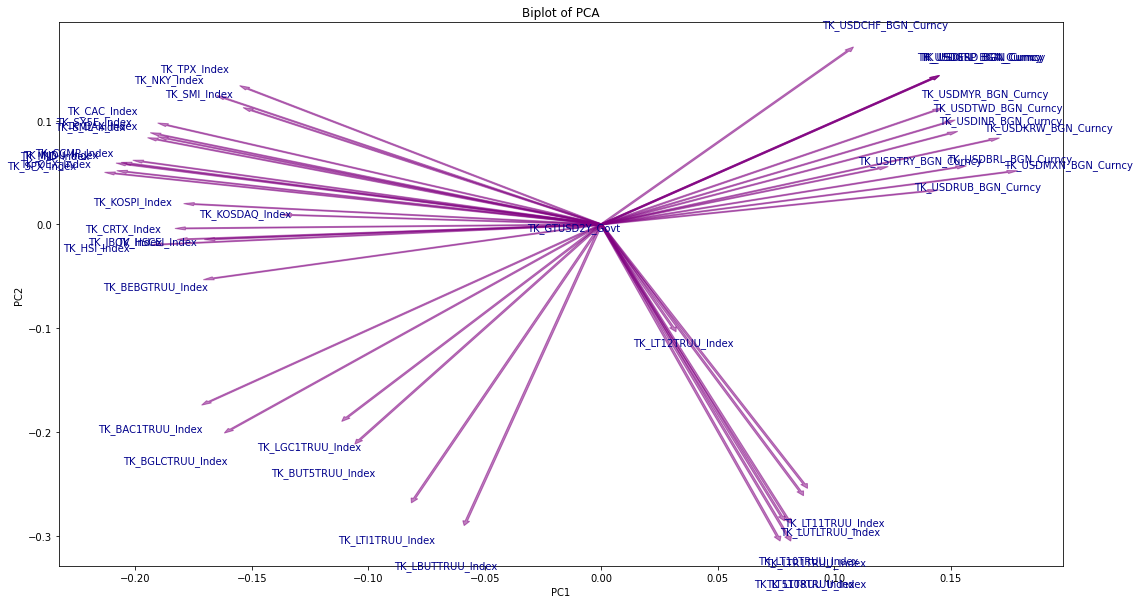

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(18,10))
plt.title('Biplot of PCA')
 
biplot(pca_array, 
       np.transpose(pca.components_), 
       list(data.columns))

### Correlation, PCA를 통한 대표 자산군 선정

In [ ]:
product = [TK_SPX_Index,TK_KOSPI_Index,TK_GTUSD2Y_Govt, TK_GTUSD10Y_Govt,TK_USDKRW_BGN_Curncy,TK_LT08TRUU_Index,TK_LT12TRUU_Index,TK_BGLCTRUU_Index,TK_LBUTTRUU_Index,TK_MXUS0CS_Index,TK_MXWO0RE_Index] # 변수 선정 이유(과정)

- 장단기 금리차(10Y-2Y) 파생변수 생성

In [ ]:
product_list = financial_PR(product)
product_merge = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how = 'outer'),product_list)

product_merge['TK_GTUSD_diff'] = product_merge['TK_GTUSD10Y_Govt'] - product_merge['TK_GTUSD2Y_Govt']
product_merge['TK_GTUSD_diff'] = product_merge['TK_GTUSD_diff'].diff(365)
product_merge['TK_GTUSD2Y_Govt'] = product_merge['TK_GTUSD2Y_Govt'].diff(365)

product_merge.drop(['TK_GTUSD10Y_Govt'],axis=1,inplace=True)

product_merge_last = product_merge.loc[:,['TK_SPX_Index','TK_KOSPI_Index']]
product_merge = product_merge.loc['2005':,:]
product_merge_last = product_merge_last.loc['2005':,:]

### Clustering

- Clustering 전 Scaling

In [ ]:
year = product_merge.copy()
year.drop(['TK_SPX_Index','TK_KOSPI_Index'],axis=1,inplace = True)

scaler = StandardScaler()

year_scr = scaler.fit_transform(year)

year_scr = pd.DataFrame(year_scr,index = year.index,columns = year.columns)

year_scr

,TK_SPX_Index_365,TK_KOSPI_Index_365,TK_GTUSD2Y_Govt,TK_USDKRW_BGN_Curncy,TK_LT08TRUU_Index,TK_LT12TRUU_Index,TK_BGLCTRUU_Index,TK_LBUTTRUU_Index,TK_MXUS0CS_Index,TK_MXWO0RE_Index,TK_GTUSD_diff
bas_dt,,,,,,,,,,,
2005-01-01,0.084893,0.056045,1.263777,-1.178106,-0.439728,-0.265118,0.399833,0.424425,-0.014583,1.168641,-1.641439
2005-01-02,0.035439,0.046242,1.263777,-1.165519,-0.440705,-0.265118,0.381221,0.417837,-0.031277,1.114790,-1.645886
2005-01-03,-0.013609,0.036462,1.263777,-1.152912,-0.441681,-0.265118,0.362610,0.411249,-0.047947,1.061557,-1.650333
2005-01-04,-0.125986,-0.011934,1.369442,-1.143770,-0.507369,-0.272873,0.265987,0.350689,-0.121166,0.942520,-1.681462
2005-01-05,-0.160592,-0.018046,1.481923,-1.057212,-0.602762,-0.278043,0.268412,0.239705,-0.140117,0.762603,-1.694803
...,...,...,...,...,...,...,...,...,...,...,...
2020-04-26,-0.688991,-1.050184,-2.045900,0.422351,2.633510,0.787896,0.387970,1.583169,-0.435143,-1.004882,0.399717
2020-04-27,-0.659841,-1.049118,-2.052717,0.405406,2.622980,0.785310,0.390600,1.601413,-0.426315,-0.953905,0.421952
2020-04-28,-0.696275,-1.047911,-2.066351,0.403856,2.686436,0.784449,0.460722,1.677937,-0.380878,-0.934325,0.359694


- GMM Model

In [ ]:
def gaussian_n_clusters(n_clusters, data):
    BIC = []
    AIC = []
    for n_cluster in n_clusters:
        gmm = GaussianMixture(n_components = n_cluster, n_init= 20).fit(data)
        BIC.append(gmm.bic(data))
        AIC.append(gmm.aic(data))

    plt.figure(figsize=(16,8), dpi=300)
    plt.plot(n_clusters, BIC, 'bo-', color='black',label='BIC')
    plt.plot(n_clusters, AIC, 'bo-', color='black',label='AIC')
    plt.xlabel('n_cluster')
    plt.title('Score of BIC & AIC')
    plt.show()

- 최적의 K 선정

In [ ]:
n_clusters = list(range(2,15))
gaussian_n_clusters(n_clusters,year_scr)

In [ ]:
gmm = GaussianMixture(n_components = 6 ,n_init= 20)
year_scr['label'] = gmm.fit_predict(year_scr)

In [ ]:
year_scr['label'].value_counts()

4    1425
1    1066
5    1017
3     868
0     789
2     434
Name: label, dtype: int64

In [ ]:
# year_scr['label'] = year_scr['label'].apply(lambda x: 2 if x == 2 else 5 if x == 1 else 0 if x == 4 else 3 if x == 3 else 4 if x == 5 else 1 )

In [ ]:
# year_scr['label'] = year_scr['label'].apply(lambda x: 3 if x == 0 else 5 if x == 1 else 2 if x == 5 else 0 if x == 4 else 4 if x == 3 else 1 )

In [ ]:
year['label'] = year_scr['label'].values
product_merge_last['label'] = year['label'].values

- 국면 0: 금융위기 이전
- 국면 1: 금융위기, 코로나
- 국면 2: 미국 국채 2년 금리의 수익률이 대부분 양으로 치우쳐 있는 시기
- 국면 3: 급격히 물가지수 연동형 국채가 상승하고, 미국 2년 국채 금리가 하락하는 시기
- 국면 4: 미국 2년 국채 금리의 변동이 크지 않은 시기 => 일반적으로 안정적인 경제 상황에서 나타나는 현상이며, 주식시장에 일반적으로 긍정적인 영향
- 금융위기 이후 국면: 물가지수 연동형 국채와 기업 채권의 수익률이 모두 양으로 치우쳐 있는 시기 -> 미래의 경제 성장을 예상

In [ ]:
for col in year.iloc[:,:-1].columns:
  plt.figure(figsize=(30, 10))
  plt.subplot(121)
  fig = sns.scatterplot(year.index,year[col],hue=year['label'],palette='coolwarm')
  fig.set(xlabel='index')
  plt.subplot(122)
  sns.kdeplot(data = year, x= col,hue='label',palette='coolwarm')
  plt.show()

- 국면 시각화 (S&P 종가)

In [ ]:
plt.figure(figsize=(24, 8))
fig = sns.scatterplot(product_merge_last.index,product_merge_last['TK_SPX_Index'],hue=product_merge_last['label'],palette=sns.blend_palette(['blue','darkblue','lightskyblue','gold','brown','lightgray']))
fig.set(xlabel='index')
plt.xticks(fontsize=20)
plt.show()

- 국면 5: 물가지수 연동형 국채와 기업 채권의 수익률이 모두 양으로 치우쳐 있는 시기 -> 미래의 경제 성장을 예상

In [ ]:
year_5 = year[year['label'] == 5]

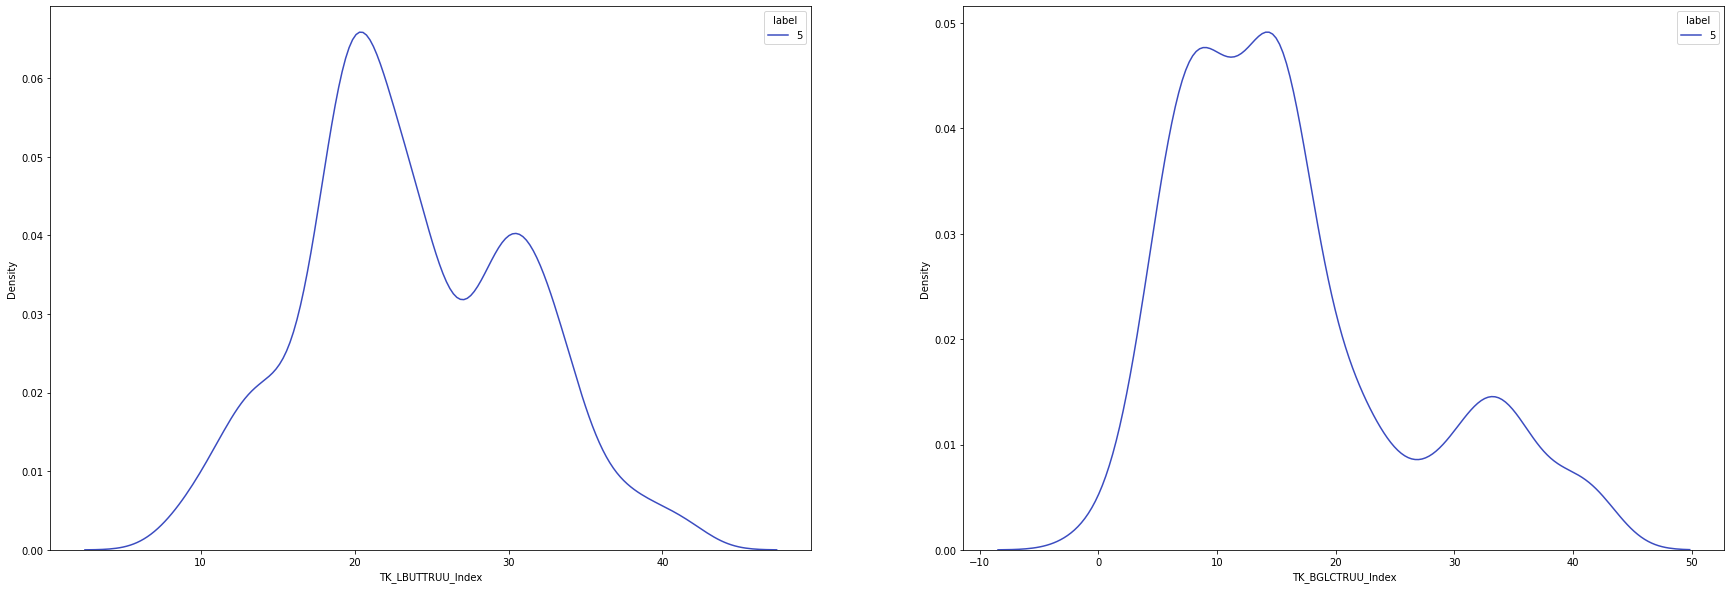

In [ ]:
plt.figure(figsize=(30, 10))
plt.subplot(121)
sns.kdeplot(data = year_5, x= 'TK_LBUTTRUU_Index',hue='label',palette='coolwarm')
plt.subplot(122)
sns.kdeplot(data = year_5, x= 'TK_BGLCTRUU_Index',hue='label',palette='coolwarm')
plt.show()

- 국면 4: 미국 2년 국채 금리의 변동이 크지 않은 시기 => 일반적으로 안정적인 경제 상황에서 나타나는 현상이며, 주식시장에 일반적으로 긍정적인 영향을 줌

In [ ]:
year_4 = year[year['label'] == 4]

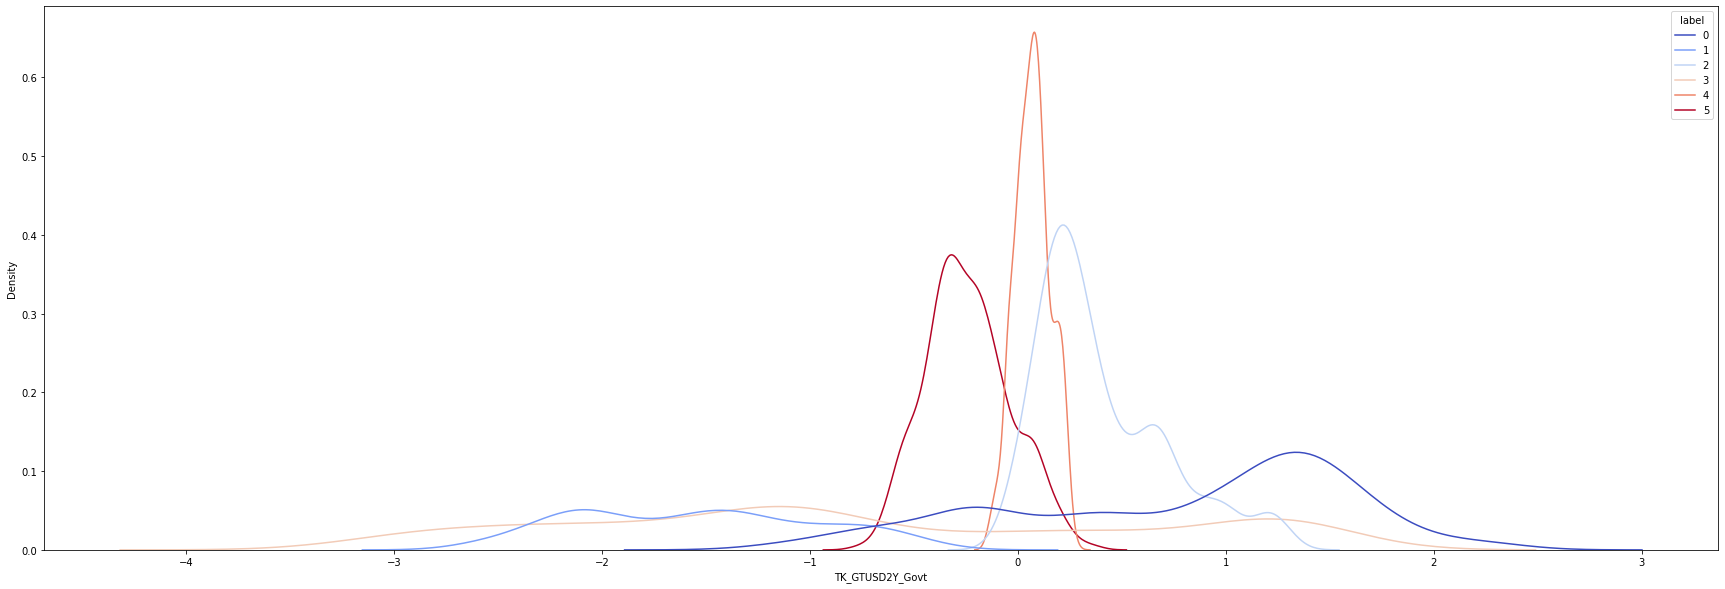

In [ ]:
plt.figure(figsize=(30, 10))
sns.kdeplot(data = year, x= 'TK_GTUSD2Y_Govt',hue='label',palette='coolwarm')
plt.show()

- 국면 2: 미국 국채 2년 금리의 수익률이 대부분 양으로 치우쳐 있는 시기

In [ ]:
year_2 = year[year['label'] == 2]

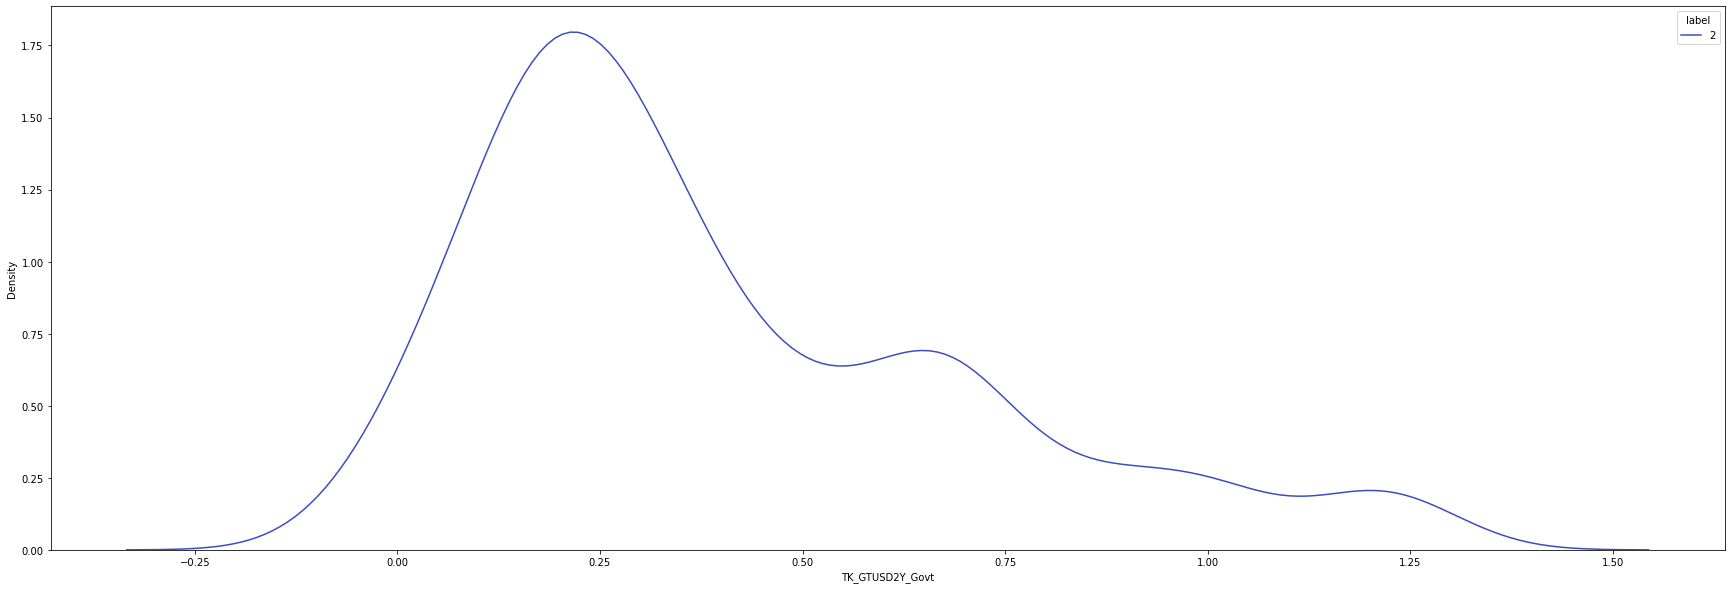

In [ ]:
plt.figure(figsize=(30, 10))
sns.kdeplot(data = year_2, x= 'TK_GTUSD2Y_Govt',hue='label',palette='coolwarm')
plt.show()

- 국면 3: 급격히 물가지수 연동형 국채가 상승하고, 미국 2년 국채 금리가 하락하는 시기

In [ ]:
year_3 = year[year['label'] == 3]
year_3_2 = year_3.loc['2016':,:]
year_3_1 = year_3.loc[:'2015',:]

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


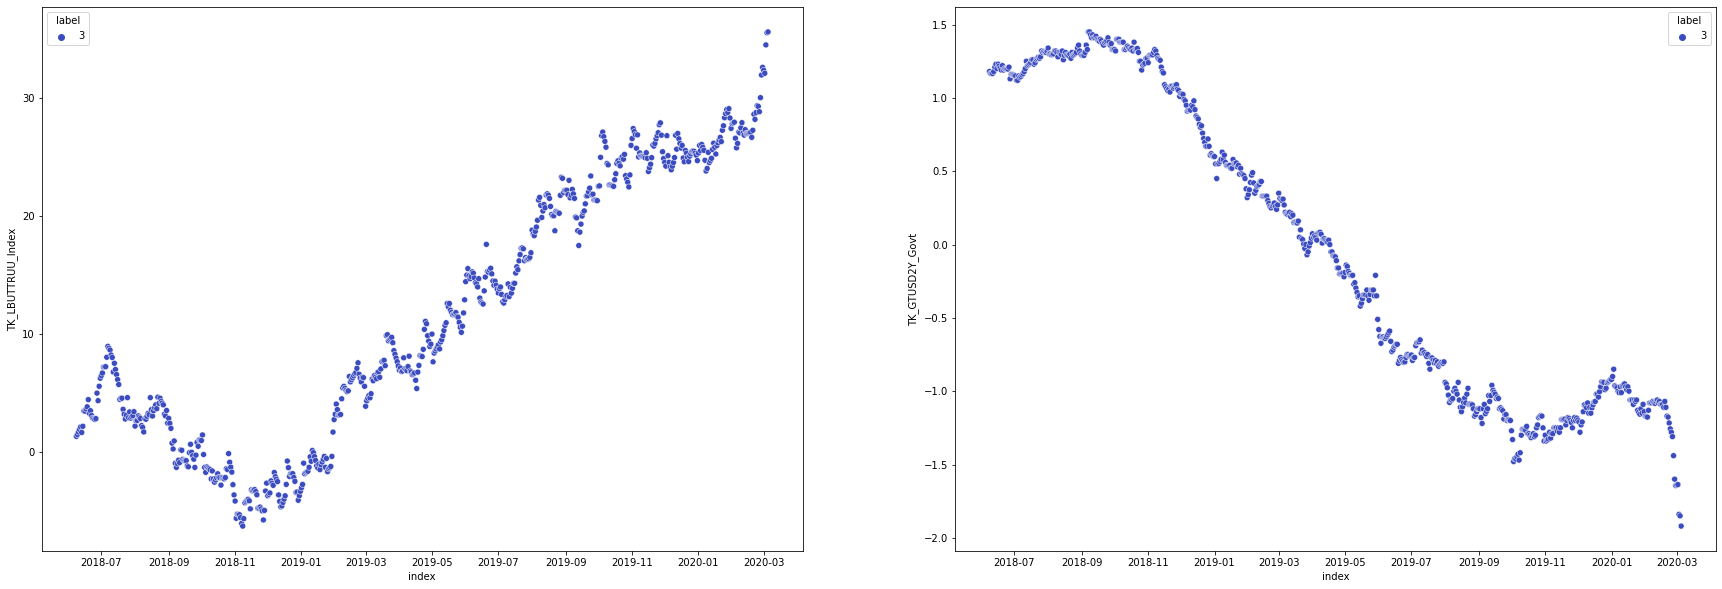

In [ ]:
plt.figure(figsize=(30, 10))
plt.subplot(121)
fig = sns.scatterplot(year_3.index,year_3['TK_LBUTTRUU_Index'],hue=year_3['label'],palette='coolwarm')
fig.set(xlabel='index')
plt.subplot(122)
fig = sns.scatterplot(year_3.index,year_3['TK_GTUSD2Y_Govt'],hue=year_3['label'],palette='coolwarm')
fig.set(xlabel='index')
plt.show()

In [ ]:
week_product_list = fr_PR(product,'W')
week_merge = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how = 'outer'),week_product_list)
week_merge.dropna(axis=0,inplace=True)

### granger 인과관계 분석

In [ ]:
week_merge1 = week_merge.loc[:'2008-09-12'] 
week_merge2 = week_merge.loc['2009-10-24':] 

- 정상성 확인

In [ ]:
from statsmodels.tsa.stattools import adfuller
i = 0
fina_list =['전','후']
for dat in [week_merge1,week_merge2]:
  print('------금융위기 {}------'.format(fina_list[i]))
  for col in dat.columns:
    result = adfuller(dat[col])
    if result[1] > 0.05:
      print('{} is not stationary'.format(col))
    else:
      print('{} is stationary'.format(col))

TK_SPX_Index is stationary
TK_KOSPI_Index is stationary
TK_GTUSD2Y_Govt is stationary
TK_USDKRW_BGN_Curncy is stationary
TK_LT08TRUU_Index is stationary
TK_LT12TRUU_Index is not stationary
TK_BGLCTRUU_Index is stationary
TK_LBUTTRUU_Index is stationary
TK_MXUS0CS_Index is stationary
TK_MXWO0RE_Index is stationary
TK_GTUSD_diff is stationary


In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

In [ ]:
grangercausalitytests(week_merge1[['TK_SPX_Index', 'TK_GTUSD2Y_Govt']], maxlag=10)

In [ ]:
grangercausalitytests(week_merge2[['TK_SPX_Index', 'TK_GTUSD2Y_Govt']], maxlag=10)